## **Activity 1. Warmup**

**Import thư viện numpy, pandas, matplotlib**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## **Activity 2. Load data and preprocessing**

**Tạo DataFrame của pandas từ file “Social_Network_Ads.csv”**

In [ ]:
data = pd.read_csv('/content/Social_Network_Ads.csv')

**Trích xuất input và output**

In [ ]:
X = data.iloc[:,[2,3]].values
y = data.iloc[:,-1:].values

**Chia dữ liệu thành train set và test set**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,
                                                    random_state = 42)

**Chuẩn hoá input**

In [ ]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std=X_train.std(axis=0,keepdims=True)
X_train_scaled = (X_train - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std

## **Activity 3. Xây dựng và huấn luyện mô hình**

**Hàm dự báo, hàm loss, gàm gradient**

In [ ]:
g = lambda z: np.exp(z)/(1+np.exp(z))

def predict_prob(X,w):
  z = np.dot(X,w.T)
  z = np.float64(z)
  return g(z)
def predict(X,w):
  y_hat = predict_prob(X,w)
  y_hat[y_hat >=0.5]=1
  y_hat[y_hat <0.5]=0
  return y_hat
def loss(X,y,w):
  y_hat = predict_prob(X,w)
  theta = 1e-3
  l = y*np.log(y_hat+theta)+(1-y)*np.log(1-y_hat+theta)
  return -np.mean(l)
def grad(X,y,w):
  y_hat = predict_prob(X,w)
  delta = y_hat - y
  dw = np.dot(X.T,delta)
  return dw.T

**Hàm batch_genrator**

In [ ]:
def batch_generator(X,y,batch_size):
  idx = np.arange(X.shape[0])
  np.random.shuffle(idx)

  n_batch = len(idx)//batch_size
  for i in range(n_batch):
    i_start = i*batch_size
    i_stop = min((i+1)*batch_size,len(idx))
    yield X[idx[i_start:i_stop],:], y[idx[i_start:i_stop],:]

**Gradient descent: viết hàm batch_genrator và thực thi thuật toán gradient với mini-batch để huấn luyện mô hình logistic regression.**

In [ ]:
def gradient_descent(X, y, lr=0.005, epochs=100):
  w = np.zeros((1,X.shape[1]))
  losses = []
  for i in range(epochs):
    for X_batch, y_batch in batch_generator(X, y, 32):
      dw = grad(X_batch, y_batch, w)
      w -= lr * dw
      a = loss(X, y, w)
      losses.append(a)
  return losses, w

In [ ]:
print(y_train.shape)

(320, 1)


In [ ]:
loss,w = gradient_descent(X_train_scaled,y_train)

In [ ]:
print(w.shape)

(1, 2)


**Vẽ hàm loss sau khi thực thi gradient descent**

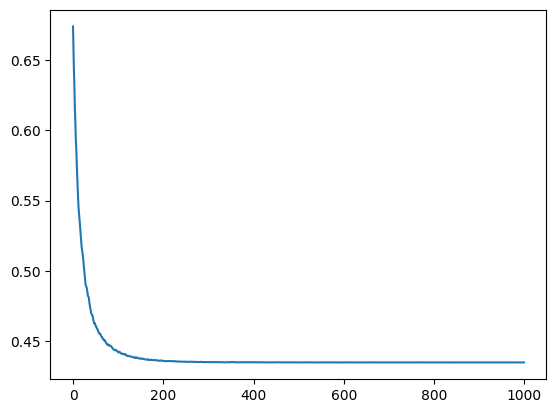

In [ ]:
plt.plot(loss)

**Tính y dự đoán**

In [ ]:
y_pred = predict(X_test_scaled,w)

In [ ]:
print(y_pred.shape)

(80, 1)


**Hàm classification_report**

In [ ]:
def classification_report(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    conf_mat = np.array([[tp, fn],[fp, tn]])
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print('Confusion matrix: \n',conf_mat)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1_score)

**Sử dụng hàm classification_report để đánh giá hiệu quả của mô hình.**

In [ ]:
classification_report(y_test, y_pred)

Confusion matrix: 
 [[28  0]
 [ 7 45]]
Accuracy: 0.9125
Precision: 0.8
Recall: 1.0
F1-score: 0.888888888888889


## **Activity 4. Xây dựng mô hình neural networks dự đoán khả năng mua hàng của khách hàng**

**Xây dựng class SigmoidLayer**

In [ ]:
g = lambda z: 1/(1+np.exp(-z))

class SigmoidLayer:
  def __init__(self,n_in,n_out,bias = True):
    if bias: n_in += 1
    w = np.random.randn(n_in,n_out)
    self.w = w
    self.bias = bias
    self.is_forward = False
  def forward(self,X):
    if self.bias:
      X = np.hstack((np.ones((X.shape[0],1)),X))
    z = np.dot(X,self.w)
    a = g(z)

    self.is_forward = True
    self.x = X
    self.a = a
    return a
  def back_propagation(self,delta):
    a = self.a
    dw = np.dot(self.x.T,delta*a*(1.0-a))

    if self.bias:
      da = np.dot(delta*a*(1.0-a),self.w.T)[:,1:]
    else:
      da = np.dot(delta*a*(1.0-a),self.w.T)
    return dw,da

In [ ]:
print(X_train_scaled.shape)

(320, 2)


**Xây dựng mô hình**

In [ ]:
NDIMS = 2
L1 = 32
L2 = 32
epochs = 500
lr = 0.02

layers = [SigmoidLayer(NDIMS,L1,bias = False),
         SigmoidLayer(L1,L2),
         SigmoidLayer(L2,1)]
def predict_proba(X,model):
  for l in model:
    X = l.forward(X)
  return X
y_pred = predict_proba(X_train_scaled,model = layers)

**Định nghĩa hàm train_step**

In [ ]:
def train_step(X,y,model,lr = 0.01):
  y_pred = predict_proba(X,model)
  delta = y_pred - y
  
  for l in reversed(model):
    dw,delta = l.back_propagation(delta)
    l.w -= lr*dw
for i in range(1000):
  train_step(X_train_scaled,y_train,model = layers)

**Hàm dự đoán**

In [ ]:
def predict(X, model):
    for layer in model:
        X = layer.forward(X)
    return np.round(X).astype(int)

**Tính y dự đoán binary và đánh giá hiệu quả của mô hình**

In [ ]:
y_pred = predict(X_test_scaled, layers)
y_test_binary = np.where(y_test >= 0.5, 1, 0)

classification_report(y_test_binary, y_pred)

Confusion matrix: 
 [[27  1]
 [ 4 48]]
Accuracy: 0.9375
Precision: 0.8709677419354839
Recall: 0.9642857142857143
F1-score: 0.9152542372881356


**Thay đổi kiến trúc của mạng neural lên thành 5 lớp, và huấn luyện với mini-batch gradient descent.**

In [ ]:
NDIMS = 2
L1 = 32
L2 = 64
L3 = 128
L4 = 48
L5 = 16
epochs = 500
lr = 0.02

layers = [SigmoidLayer(NDIMS,L1,bias = True),
         SigmoidLayer(L1,L2,bias = True),
         SigmoidLayer(L2,L3,bias = True),
         SigmoidLayer(L3,L4,bias = True),
         SigmoidLayer(L4,L5,bias = True),
         SigmoidLayer(L5,1,bias = True)]

**Sử dụng hàm batch_gerator để thực thi mini-batch gradient descent**

In [ ]:
def train_step(X,y,model,lr = 0.001):
  y_pred = predict_proba(X,model)
  delta = y_pred - y
  
  for l in reversed(model):
    dw,delta = l.back_propagation(delta)
    l.w -= lr*dw
for i in range(2000):
    for X_batch, y_batch in batch_generator(X_train_scaled, y_train, 32):
        train_step(X_batch,y_batch,model = layers)

**Hàm dự đoán**

In [ ]:
def predict(X, model):
    for layer in model:
        X = layer.forward(X)
    return np.round(X).astype(int)

**Tính y dự đoán binary**

In [ ]:
y_pred = predict(X_test_scaled, layers)
y_test_binary = np.where(y_test >= 0.5, 1, 0)

**Đánh giá hiệu quả của mô hình bằng hàm classification_report sau khi thay đổi số nơron**

In [ ]:
classification_report(y_test_binary, y_pred)

Confusion matrix: 
 [[27  1]
 [ 4 48]]
Accuracy: 0.9375
Precision: 0.8709677419354839
Recall: 0.9642857142857143
F1-score: 0.9152542372881356


In [ ]:
import tensorflow as tf